## MultiPEC Validation: Simulation

#### This notebook generates a simulation of three information sources (letters, digits and mix of the two) as a binary code distributed across a network of nodes.
#### MultiPEC algorithm is applied to the simulation to identify the networks.
#### The identified networks are compared to the ground truth. Network accuracy and PEC value are evaluated. 

Import dependencies.

In [1]:
from multipec.simulation_utils import sim2nets, sim3nets, random_stimulus, PEC_pairs, direct, multipec, set_plotting_style
from string import ascii_letters, digits
import pandas as pd
from collections import defaultdict
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene, kruskal, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols


Define paths.

In [2]:
from pathlib import Path

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()
results_folder = project_root / "data" / "output" / "simulation"
results_folder.mkdir(parents=True, exist_ok=True)

figures_folder = project_root / "data" / "figures" / "simulation"
figures_folder.mkdir(parents=True, exist_ok=True)


Define simulation parameters.

In [ ]:
subnetwork_number = 3 # Number of networks (stimuli) in a simulation
bits_number = 6 # Number of bits representing a stimulus (5 or 6)
test_number = 1

assert subnetwork_number in [2,3]
assert bits_number in [5,6]

N,bits,rounds = subnetwork_number,bits_number,test_number

fs=10 # Number of repetitions per stimulus
seq_multiplier=10 # Number of repetitions per stimulus sequence
n = 6 # Number of characters per stimulus

letter = [l for l in ascii_letters if l.isupper()]
number = list(digits)
base = ["@","="]


Run simulation.

In [ ]:
stimuli_log, channel_log, result_log, pec_log = [],[],[],[]

for i in range(1,rounds+1):
    print("round {}/{}".format(i,rounds))
    A,B,C=[],[],[]
    for j in range(n):
        let = random_stimulus(8, letter)
        num = random_stimulus(8, number)
        mix = random_stimulus(8, letter, number)
        A.append(let)
        B.append(num)
        C.append(mix)
    stimuli_log.append([A,B,C])
    stimuli2 = A+B
    stimuli3 = A+B+C
    print(stimuli3)

    labels2,labels3=[],[]
    if bits==6:
        labels2=["a1","a2","a3","a4","a5","a6","b1","b2","b3","b4","b5","b6"]
        labels3=["a1","a2","a3","a4","a5","a6","b1","b2","b3","b4","b5","b6","c1","c2","c3","c4","c5","c6"]
    elif bits==5:
        labels2=["a1","a2","a3","a4","a5","b1","b2","b3","b4","b5"]
        labels3=["a1","a2","a3","a4","a5","b1","b2","b3","b4","b5","c1","c2","c3","c4","c5"]
    
    all_nodes,nets = {},[]
    if N==2:
        print("\nsimulating 2 networks...")
        seq2,a_channels2,b_channels2 = sim2nets(stimuli2, A, B, fs, seq_multiplier, base, bits=bits)
        for id,ch in enumerate(a_channels2+b_channels2): all_nodes[id]=ch
        pairs2 = PEC_pairs(all_nodes)
        directed_pairs2 = direct(pairs2, list(all_nodes.keys()))
        print("\nfinding networks...")
        nonselected_nodes=list(range(len(labels2)))
        nets = multipec(all_nodes,labels2,directed_pairs2,nonselected_nodes,n_nets=len(directed_pairs2))

    elif N==3:
        print("\nsimulating 3 networks...")
        seq3,a_channels3,b_channels3,c_channels3 = sim3nets(stimuli3, A, B, C, fs, seq_multiplier, base, bits=bits)
        for id,ch in enumerate(a_channels3+b_channels3+c_channels3): all_nodes[id]=ch
        pairs3 = PEC_pairs(all_nodes)
        directed_pairs3 = direct(pairs3, list(all_nodes.keys()))
        print("\nfinding networks...")
        nonselected_nodes=list(range(len(labels3)))
        nets = multipec(all_nodes,labels3,directed_pairs3,nonselected_nodes,n_nets=len(directed_pairs3))

    found_nets=[subnet[0] for subnet in nets]
    pec=[subnet[1] for subnet in nets]
    print("\nfound {} networks".format(str(len(found_nets))))

    channel_log.append(list(all_nodes.values()))
    result_log.append(found_nets)
    pec_log.append(pec)

    print("saving {}...".format(i))
    stimuli_table = pd.DataFrame(stimuli_log, columns=["A","B","C"]) 
    channel_table = pd.DataFrame(channel_log)
    combined_table = pd.DataFrame({'nets': result_log[0],
                                   'pec': pec_log[0]})
    # Save combined table
    combined_table.to_excel(results_folder/"multi/{}nets_{}bits.xlsx".format(N,bits), index=False)
    stimuli_table.to_excel(results_folder/"multi/{}nets_{}bits_stimuli.xlsx".format(N,bits))
    channel_table.to_excel(results_folder/"multi/{}nets_{}bits_channels.xlsx".format(N,bits))


    print("Saved.")


Define ground truth groups based on the number of networks and bits.

In [ ]:
group_a, group_b, group_c = set(), set(), set()

N, bits = 2, 5

if N==2:
    if bits==5:
        group_a = {0, 1, 2, 3, 4}
        group_b = {5, 6, 7, 8, 9}
    elif bits==6:
        group_a = {0, 1, 2, 3, 4, 5}
        group_b = {6, 7, 8, 9, 10, 11}

elif N==3:
    if bits==5:
        group_a = {0, 1, 2, 3, 4}
        group_b = {5, 6, 7, 8, 9}
        group_c = {10, 11, 12, 13, 14}
    elif bits==6:
        group_a = {0, 1, 2, 3, 4, 5}
        group_b = {6, 7, 8, 9, 10, 11}
        group_c = {12, 13, 14, 15, 16, 17}

Set a universal plotting style.

In [6]:
set_plotting_style()

Plot PEC evolution for simulation configuration determined by N and bits variables defined above.

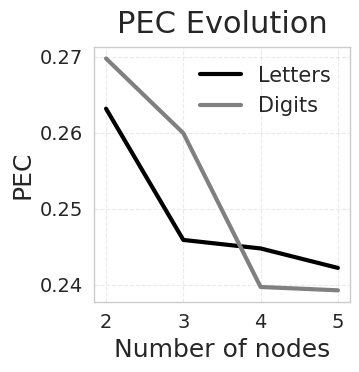

In [105]:
results_df = pd.read_excel(project_root/"data/output/simulation/multi/{}nets_{}bits.xlsx".format(N,bits), index_col=False)

e1 = None
e2 = None
e3 = None

for idx, row in results_df.iterrows():
    net_tuple = ast.literal_eval(row['nets'])
    net_set = set(net_tuple)

    if N == 2:
        if e1 == None and net_set == group_a:
            e1 = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]
        elif e2 == None and net_set == group_b:
            e2 = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]
        if e1 != None and e2 != None:
            break

    elif N == 3:
        if e1 == None and net_set == group_a:
            e1 = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]
        elif e2 == None and net_set == group_b:
            e2 = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]
        if e3 == None and net_set == group_c:
            e3 = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]
        if e1 != None and e2 != None and e3 != None:
            break

plt.figure(figsize=(4, 4))

plt.plot(e1, linewidth=3, color="black", label="Letters")
plt.plot(e2, linewidth=3, color="grey", label="Digits")

if  N == 3:
    plt.plot(e3, linewidth=5, color="grey", label="Mix", linestyle='--')

plt.title("PEC Evolution", pad=10)
plt.xticks(ticks=list(range(len(e2))), labels=list(range(2, len(e2)+2)))
plt.xlabel("Number of nodes")
plt.ylabel("PEC")

plt.tight_layout()
plt.legend()
# Save high-res
plt.savefig(figures_folder/"PEC_evolution_{}nets_{}bits.png".format(N, bits), dpi=300)

plt.show()


For the same configuration as above, plot PEC distribution for networks grouped based on their accuracy: perfect prediction, subset or imperfect prediction.

Skipping group 'Subset' due to insufficient data (n=3)

Shapiro-Wilk normality tests:
Perfect: W=0.929, p=0.212 
Imperfect: W=0.876, p=0.006 (not normal)

Levene’s test for equal variances: W=10.573, p=0.002

Running Kruskal-Wallis and Mann–Whitney post-hoc
Kruskal-Wallis H=29.651, p=0.000
Perfect vs Imperfect: U=0.0, p=0.0000000556


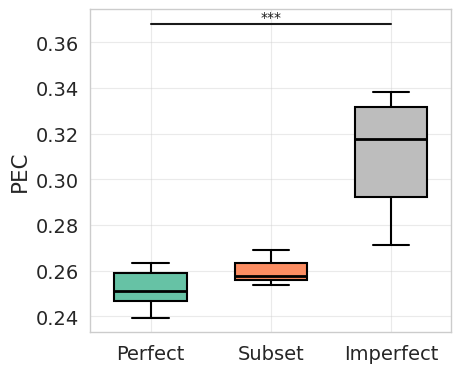

In [117]:
results_df = pd.read_excel(
    project_root / f"data/output/simulation/multi/{N}nets_{bits}bits.xlsx",
    index_col=False
)
grouped = defaultdict(list)

for idx, row in results_df.iterrows():
    net_tuple = ast.literal_eval(row['nets'])
    net_nodes = set(net_tuple)
    pec_value = [float(e.strip()) for e in row['pec'].strip("[]").split(",")][-1]

    if N == 2:
        if net_nodes == group_a or net_nodes == group_b:
            category = "Perfect"
        elif net_nodes.issubset(group_a) or net_nodes.issubset(group_b):
            category = "Subset"
        else:
            category = "Imperfect"
    elif N == 3:
        if net_nodes in [group_a, group_b, group_c]:
            category = "Perfect"
        elif (net_nodes.issubset(group_a) or
              net_nodes.issubset(group_b) or
              net_nodes.issubset(group_c)):
            category = "Subset"
        else:
            category = "Imperfect"

    grouped[category].append(pec_value)

sns.set(style="whitegrid", context="paper", font_scale=1.6)

labels = ["Perfect", "Subset", "Imperfect"]
data = [grouped[label] for label in labels]

# Filter groups with < 3 samples to avoid errors in tests
filtered_labels = []
filtered_data = []
for label, vals in zip(labels, data):
    if len(vals) >= 5:
        filtered_labels.append(label)
        filtered_data.append(vals)
    else:
        print(f"Skipping group '{label}' due to insufficient data (n={len(vals)})")

# Flatten data for ANOVA/Tukey
data_long = pd.DataFrame({
    "PEC": sum(filtered_data, []),
    "Group": sum([[label]*len(vals) for label, vals in zip(filtered_labels, filtered_data)], [])
})

def get_significance_label(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'n.s.'

print("\nShapiro-Wilk normality tests:")
normality = []
for label, vals in zip(filtered_labels, filtered_data):
    stat, p = shapiro(vals)
    normality.append(p > 0.05)
    print(f"{label}: W={stat:.3f}, p={p:.3f} {'(not normal)' if p<0.05 else ''}")

stat, levene_p = levene(*filtered_data)
print(f"\nLevene’s test for equal variances: W={stat:.3f}, p={levene_p:.3f}")

sig_results = {}
if len(filtered_data) >= 2:
    if all(normality) and levene_p > 0.05:
        print("\n→ Running ANOVA with Tukey post-hoc")
        model = ols('PEC ~ Group', data=data_long).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)

        tukey = pairwise_tukeyhsd(endog=data_long["PEC"], groups=data_long["Group"], alpha=0.05)
        print(tukey)

        # Collect significance from Tukey for plotting
        for res in tukey._results_table.data[1:]:
            g1, g2, meandiff, p_adj, lower, upper, reject = res
            sig_results[(g1, g2)] = get_significance_label(p_adj)

    else:
        print("\nRunning Kruskal-Wallis and Mann–Whitney post-hoc")
        stat, p = kruskal(*filtered_data)
        print(f"Kruskal-Wallis H={stat:.3f}, p={p:.3f}")

        for (i, j) in combinations(range(len(filtered_labels)), 2):
            u_stat, u_p = mannwhitneyu(filtered_data[i], filtered_data[j], alternative='two-sided')
            sig_results[(filtered_labels[i], filtered_labels[j])] = get_significance_label(u_p)
            print(f"{filtered_labels[i]} vs {filtered_labels[j]}: U={u_stat}, p={u_p:.10f}")
else:
    print(f"Not enough groups with sufficient samples for stats in N={N}, bits={bits}")
    
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
bp = ax.boxplot(data,
                tick_labels=labels,
                patch_artist=True,
                widths=0.6,
                showfliers=False,
                medianprops=dict(color="black", linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5),
                boxprops=dict(linewidth=1.5))

colors = ["#66c2a5", "#fc8d62", "#bdbdbd"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel("PEC")
ax.set_title("")
ax.tick_params(axis='both', which='major')

y_max = max([max(group) for group in filtered_data])
y_min = min([min(group) for group in filtered_data])
y_range = y_max - y_min

for i, (g1, g2) in enumerate(combinations(labels, 2)):
    x1, x2 = labels.index(g1) + 1, labels.index(g2) + 1
    y, h, col = y_max + (i + 0.5) * 0.2 * y_range, 0, 'k'
    significance = sig_results.get((g1, g2)) or sig_results.get((g2, g1)) or 'n.s.'

    # Only annotate if significance result is known (groups had enough samples)
    if (g1 in filtered_labels) and (g2 in filtered_labels):
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col, fontsize=10)


plt.tight_layout()
plt.savefig(figures_folder / f"PEC_by_group_{N}nets_{bits}bits_annotated.png", dpi=300)
plt.show()


Make a scatter plot of PEC vs ground truth overlap.

In [ ]:
sns.set(style="whitegrid", context="paper", font_scale=1.5)

accuracies = []
pec_values = []
categories = []
colors = []

color_map = {
    "Perfect": "#66c2a5",
    "Subset": "#fc8d62", 
    "Imperfect": "#bdbdbd"
}
for idx, row in results_df.iterrows():
    net_tuple = ast.literal_eval(row['nets'])
    net_nodes = set(net_tuple)
    pec_value = [float(e.strip()) for e in row['pec'].strip("[]").split(",")][-1]

    if N == 2:
        overlap_a = len(net_nodes & group_a)
        overlap_b = len(net_nodes & group_b)
        max_overlap = max(overlap_a, overlap_b)
        accuracy = max_overlap / len(net_nodes)

        if net_nodes == group_a or net_nodes == group_b:
            category = "Perfect"
        elif net_nodes.issubset(group_a) or net_nodes.issubset(group_b):
            category = "Subset"
        else:
            category = "Imperfect"

    elif N == 3:
        overlap_a = len(net_nodes & group_a)
        overlap_b = len(net_nodes & group_b)
        overlap_c = len(net_nodes & group_c)
        max_overlap = max(overlap_a, overlap_b, overlap_c)
        accuracy = max_overlap / len(net_nodes)

        if net_nodes in [group_a, group_b, group_c]:
            category = "Perfect"
        elif (net_nodes.issubset(group_a) or
              net_nodes.issubset(group_b) or
              net_nodes.issubset(group_c)):
            category = "Subset"
        else:
            category = "Imperfect"

    accuracies.append(accuracy)
    pec_values.append(pec_value)
    categories.append(category)
    colors.append(color_map[category])


plt.figure()

for cat in ["Perfect", "Subset", "Imperfect"]:
    xs = [acc for acc, c in zip(accuracies, categories) if c == cat]
    ys = [pec for pec, c in zip(pec_values, categories) if c == cat]
    plt.scatter(xs, ys,
                label=cat,
                color=color_map[cat],
                edgecolor='k',
                s=70,
                alpha=0.75)

plt.xlabel("Accuracy")
plt.ylabel("PEC")
plt.title("PEC vs. Network Accuracy", pad=10)
plt.xlim(-0.05, 1.05)
plt.legend(title="Category", loc='upper left')
plt.tight_layout()

plt.savefig(figures_folder/"PEC_vs_Accuracy_{}nets_{}bits.png".format(N, bits))

plt.show()


Check correlation between network seed (node pair) PEC (PEC[2]) and network PEC (PEC[n]). 

Pearson correlation between pec[0] and pec[1]: 0.9077
P-value: 7.8403e-26


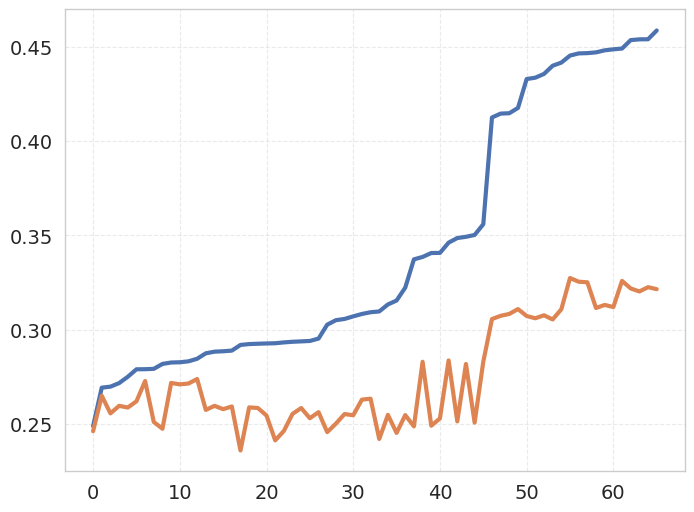

In [ ]:
from scipy.stats import pearsonr

results_df = pd.read_excel(
    project_root / f"data/output/simulation/multi/{N}nets_{bits}bits.xlsx",
    index_col=False
)

pec_0 = []
pec_1 = []

for idx, row in results_df.iterrows():
    pec_list = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]
    pec_0.append(pec_list[0])
    pec_1.append(pec_list[-1])

# Compute Pearson correlation
corr, p_value = pearsonr(pec_0, pec_1)

print(f"Pearson correlation between PEC[2] and PEC[n]: {corr:.4f}")
print(f"P-value: {p_value:.4e}")

plt.plot(pec_0)
plt.plot(pec_1)


Now, make composite figures of PEC evolution and PEC distribution across network groups, including all configurations.

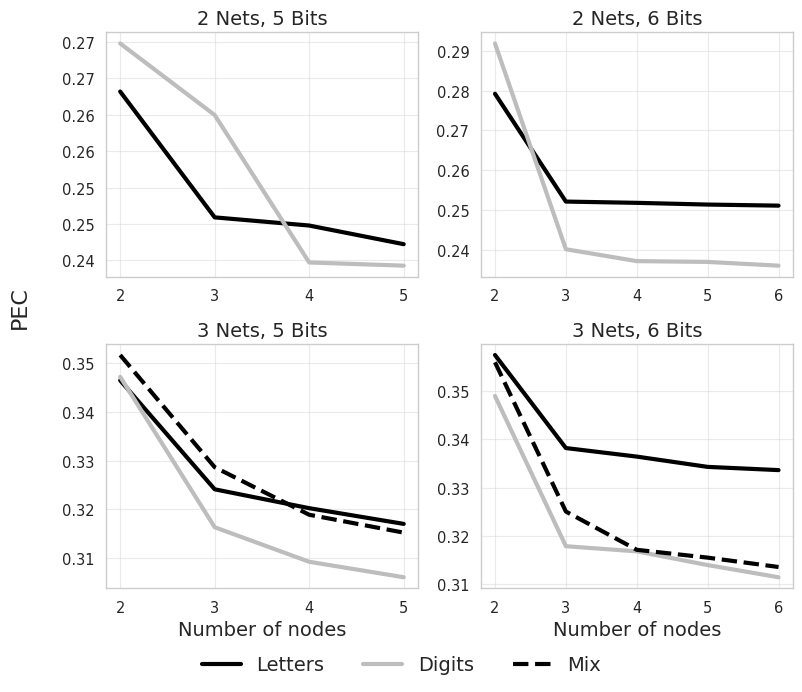

In [80]:
# Define scenarios
scenarios = [(2, 5), (2, 6), (3, 5), (3, 6)]

# Store results for each subplot
plot_data = []

for N, bits in scenarios:

    # Define ground truth groups based on the number of networks and bits
    group_a, group_b, group_c = set(), set(), set()
    if N==2:
        if bits==5:
            group_a = {0, 1, 2, 3, 4}
            group_b = {5, 6, 7, 8, 9}
        elif bits==6:
            group_a = {0, 1, 2, 3, 4, 5}
            group_b = {6, 7, 8, 9, 10, 11}

    elif N==3:
        if bits==5:
            group_a = {0, 1, 2, 3, 4}
            group_b = {5, 6, 7, 8, 9}
            group_c = {10, 11, 12, 13, 14}
        elif bits==6:
            group_a = {0, 1, 2, 3, 4, 5}
            group_b = {6, 7, 8, 9, 10, 11}
            group_c = {12, 13, 14, 15, 16, 17}


    file_path = project_root/"data/output/simulation/multi/{}nets_{}bits.xlsx".format(N,bits)
    try:
        results_df = pd.read_excel(file_path, index_col=False)
    except FileNotFoundError:
        continue

    e1 = e2 = e3 = None

    for idx, row in results_df.iterrows():
        try:
            net_tuple = ast.literal_eval(row['nets'])
            net_set = set(net_tuple)
            pec_vals = [float(e.strip()) for e in row['pec'].strip("[]").split(",")]

            if N == 2:
                if e1 is None and net_set == group_a:
                    e1 = pec_vals
                elif e2 is None and net_set == group_b:
                    e2 = pec_vals
                if e1 is not None and e2 is not None:
                    break
            elif N == 3:
                if e1 is None and net_set == group_a:
                    e1 = pec_vals
                elif e2 is None and net_set == group_b:
                    e2 = pec_vals
                elif e3 is None and net_set == group_c:
                    e3 = pec_vals
                if e1 is not None and e2 is not None and e3 is not None:
                    break
        except Exception:
            continue

    plot_data.append((N, bits, e1, e2, e3))

# Plot all scenarios into one figure
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
axes = axes.flatten()

for ax, (N, bits, e1, e2, e3) in zip(axes, plot_data):
    if e1 is None or e2 is None:
        continue

    ax.plot(e1, linewidth=3, color="black", label="Letters")  # green-teal
    ax.plot(e2, linewidth=3, color="#bdbdbd", label="Digits")   # orange
    if N == 3 and e3 is not None:
        ax.plot(e3, linewidth=3, color="black", linestyle='--', label="Mix")  # purple dashed


    ax.set_title(f"{N} Nets, {bits} Bits", size=14)
    ax.set_xticks(list(range(len(e2))))
    ax.set_xticklabels(list(range(2, len(e2)+2)))
    if N==3: ax.set_xlabel("Number of nodes", fontsize=14)
    # Format y-ticks to 2 decimal places
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))


# Add shared x-label and y-label
fig.text(0.00, 0.55, 'PEC', va='center', rotation='vertical', fontsize=16)

# Shared legend and layout
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=14)
plt.tight_layout(rect=[0.06, 0.05, 1, 1])
plt.subplots_adjust(left=0.12)  # increase left margin to fit label

plt.savefig(figures_folder / "PEC_evolution_composite.png", dpi=300)
plt.show()


Perfect Prediction 17
Subset 3
Skipping group 'Subset' in N=2, bits=5 due to insufficient samples (n=3)
Imperfect Prediction 25
Kruskal-Wallis H=29.651, p=0.00000005172159466295 for N=2, bits=5
Perfect Prediction vs Imperfect Prediction: U=0.0, p=0.00000005557752873173
Perfect Prediction 12
Subset 17
Imperfect Prediction 37
Kruskal-Wallis H=27.441, p=0.00000109943607284090 for N=2, bits=6
Perfect Prediction vs Subset: U=26.0, p=0.00082819323877218168
Perfect Prediction vs Imperfect Prediction: U=42.0, p=0.00003002320869162231
Subset vs Imperfect Prediction: U=119.0, p=0.00028148184620721377
Perfect Prediction 29
Subset 1
Skipping group 'Subset' in N=3, bits=5 due to insufficient samples (n=1)
Imperfect Prediction 75
Kruskal-Wallis H=62.143, p=0.00000000000000319424 for N=3, bits=5
Perfect Prediction vs Imperfect Prediction: U=0.0, p=0.00000000000000328826
Perfect Prediction 27
Subset 17
Imperfect Prediction 106
Kruskal-Wallis H=66.112, p=0.00000000000000440529 for N=3, bits=6
Perfect P

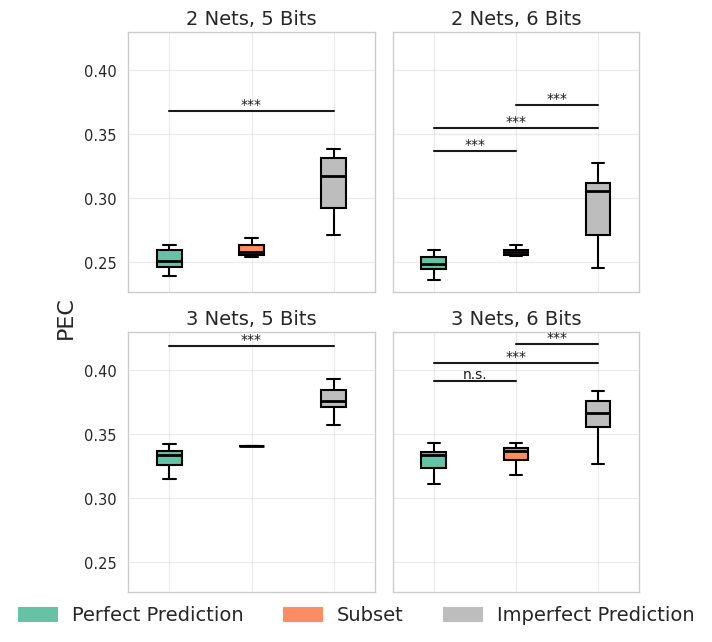

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from itertools import combinations
from scipy.stats import mannwhitneyu, shapiro, levene, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import defaultdict
import pandas as pd
import ast
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(style="whitegrid", context="paper", font_scale=1.2)

scenarios = [
    (2, 5),
    (2, 6),
    (3, 5),
    (3, 6)
]

labels = ["Perfect Prediction", "Subset", "Imperfect Prediction"]
colors = ["#66c2a5", "#fc8d62", "#bdbdbd"]  # colorblind-friendly
MIN_SAMPLES = 5  # minimum samples to perform stats

fig, axes = plt.subplots(2, 2, figsize=(6, 6.5), sharey=True)
axes = axes.flatten()

def get_significance_label(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'n.s.'

for ax, (N, bits) in zip(axes, scenarios):

    # Define ground truth groups based on the number of networks and bits
    group_a, group_b, group_c = set(), set(), set()
    if N==2:
        if bits==5:
            group_a = {0, 1, 2, 3, 4}
            group_b = {5, 6, 7, 8, 9}
        elif bits==6:
            group_a = {0, 1, 2, 3, 4, 5}
            group_b = {6, 7, 8, 9, 10, 11}

    elif N==3:
        if bits==5:
            group_a = {0, 1, 2, 3, 4}
            group_b = {5, 6, 7, 8, 9}
            group_c = {10, 11, 12, 13, 14}
        elif bits==6:
            group_a = {0, 1, 2, 3, 4, 5}
            group_b = {6, 7, 8, 9, 10, 11}
            group_c = {12, 13, 14, 15, 16, 17}

    # Load and group data
    results_df = pd.read_excel(
        project_root / f"data/output/simulation/multi/{N}nets_{bits}bits.xlsx",
        index_col=False
    )
    grouped = defaultdict(list)

    for idx, row in results_df.iterrows():
        net_tuple = ast.literal_eval(row['nets'])
        net_nodes = set(net_tuple)
        pec_value = [float(e.strip()) for e in row['pec'].strip("[]").split(",")][-1]

        if N == 2:
            if net_nodes == group_a or net_nodes == group_b:
                category = "Perfect Prediction"
            elif net_nodes.issubset(group_a) or net_nodes.issubset(group_b):
                category = "Subset"
            else:
                category = "Imperfect Prediction"
        elif N == 3:
            if net_nodes in [group_a, group_b, group_c]:
                category = "Perfect Prediction"
            elif (net_nodes.issubset(group_a) or
                  net_nodes.issubset(group_b) or
                  net_nodes.issubset(group_c)):
                category = "Subset"
            else:
                category = "Imperfect Prediction"

        grouped[category].append(pec_value)

    data = [grouped[label] for label in labels]

    # Filter groups with insufficient data for stats
    filtered_labels = []
    filtered_data = []
    for label_, vals_ in zip(labels, data):
        print(label_, len(vals_))
        if len(vals_) >= MIN_SAMPLES:
            filtered_labels.append(label_)
            filtered_data.append(vals_)
        else:
            print(f"Skipping group '{label_}' in N={N}, bits={bits} due to insufficient samples (n={len(vals_)})")

    bp = ax.boxplot(data,
                    tick_labels=labels,
                    patch_artist=True,
                    showfliers=False,
                    medianprops=dict(color="black", linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    boxprops=dict(linewidth=1.5))

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(f"{N} Nets, {bits} Bits", size=14)
    ax.tick_params(axis='both', which='major')

    # Prepare significance dictionary
    sig_results = {}

    # Only run stats if at least 2 groups have sufficient data
    if len(filtered_data) >= 2:
        # Test normality of each group
        normality = [shapiro(vals)[1] > 0.05 for vals in filtered_data]

        # Test homogeneity of variances
        levene_p = levene(*filtered_data)[1] if len(filtered_data) > 1 else 1.0

        # Prepare data for ANOVA if normality & homoscedasticity hold
        data_long = pd.DataFrame({
            "PEC": sum(filtered_data, []),
            "Group": sum([[label]*len(vals) for label, vals in zip(filtered_labels, filtered_data)], [])
        })

        if all(normality) and levene_p > 0.05:
            # Parametric ANOVA + Tukey
            model = ols('PEC ~ Group', data=data_long).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            print(f"ANOVA results for N={N}, bits={bits}\n", anova_table)

            tukey = pairwise_tukeyhsd(endog=data_long["PEC"], groups=data_long["Group"], alpha=0.05)

            # Collect pairwise significance labels from Tukey
            for res in tukey._results_table.data[1:]:
                g1, g2, meandiff, p_adj, lower, upper, reject = res
                sig_results[(g1, g2)] = get_significance_label(p_adj)

        else:
            # Non-parametric Kruskal-Wallis + Mann-Whitney
            stat, p = kruskal(*filtered_data)
            print(f"Kruskal-Wallis H={stat:.3f}, p={p:.20f} for N={N}, bits={bits}")

            for (i, j) in combinations(range(len(filtered_labels)), 2):
                u_stat, u_p = mannwhitneyu(filtered_data[i], filtered_data[j], alternative='two-sided')
                sig_results[(filtered_labels[i], filtered_labels[j])] = get_significance_label(u_p)
                print(f"{filtered_labels[i]} vs {filtered_labels[j]}: U={u_stat}, p={u_p:.20f}")
    else:
        print(f"Not enough groups with sufficient samples for stats in N={N}, bits={bits}")

    # Add significance annotations between all pairs of labels on full labels list
    y_max = max([max(group) if group else 0 for group in data])
    y_min = min([min(group) if group else 0 for group in data])
    y_range = y_max - y_min if y_max != y_min else 1

    for i, (g1, g2) in enumerate(combinations(labels, 2)):
        x1, x2 = labels.index(g1) + 1, labels.index(g2) + 1
        y, h, col = y_max + (i + 0.5) * 0.2 * y_range, 0, 'k'
        significance = sig_results.get((g1, g2)) or sig_results.get((g2, g1)) or 'n.s.'

        # Only annotate if significance result is known (groups had enough samples)
        if (g1 in filtered_labels) and (g2 in filtered_labels):
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col, fontsize=10)

# Remove x-axis labels for all subplots for cleaner look
for ax in axes:
    ax.set_xticklabels([])

# Create and add shared legend
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, labels)]
fig.legend(handles=patches, loc='lower center', ncol=3, frameon=False, fontsize=14)

# Add shared x-label and y-label
fig.text(0.0, 0.5, 'PEC', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.subplots_adjust(left=0.12)  # increase left margin to fit label
plt.savefig(figures_folder / "PEC_by_group_composite.png", dpi=300)
plt.show()
